# Forecasting model - DL Approach using LSTM

#### Importing Libraries

In [535]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster

#### Reading data

In [536]:
df_06 = pd.read_csv('data/radar_count_2022_01_06.csv', index_col=0)
df_07 = pd.read_csv('data/radar_count_2022_07_12.csv', index_col=0)

df = pd.concat([df_06, df_07], axis=0)
df

,entity_id,faixa,vehiclelight,speedlight,vehicleheavy,speedheavy,vehicleothers,speedothers,accelerationlight,accelerationheavy,accelerationothers
time_index,,,,,,,,,,,
2022-03-29 00:00:00+00,urn:ngsi-ld:Count:aveiro_radar:p33,1,0,0.000000,0,0.000000,2,3.407759,0.000000,0.000000,0.000175
2022-03-29 00:00:01+00,urn:ngsi-ld:Count:aveiro_radar:p33,2,0,0.000000,0,0.000000,1,1.460000,0.000000,0.000000,0.000271
2022-03-29 00:00:00+00,urn:ngsi-ld:Count:aveiro_radar:p1,1,1,10.664516,0,0.000000,0,0.000000,0.000335,0.000000,0.000000
2022-03-29 00:00:00+00,urn:ngsi-ld:Count:aveiro_radar:p35,1,3,14.599231,1,9.177778,0,0.000000,0.000445,0.000500,0.000000
2022-03-29 00:00:01+00,urn:ngsi-ld:Count:aveiro_radar:p35,2,1,11.525619,0,0.000000,0,0.000000,-0.001053,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23 23:57:01+00,urn:ngsi-ld:Count:aveiro_radar:p35,2,5,14.690704,0,0.000000,2,12.867460,-0.292966,0.000000,-0.089867
2022-12-23 23:58:00+00,urn:ngsi-ld:Count:aveiro_radar:p35,1,3,13.763913,0,0.000000,1,15.140909,0.088845,0.000000,-0.098329
2022-12-23 23:58:01+00,urn:ngsi-ld:Count:aveiro_radar:p35,2,0,0.000000,1,12.718085,5,11.793593,0.000000,-0.195497,-0.267829


#### Dropping the columns which are not required 
##### Faixa, speeds, acceleration

In [537]:
# now we can drop the columns we don't need
df.drop(['faixa', 'speedlight', 'speedheavy', 'speedothers', 'accelerationlight', 'accelerationheavy', 'accelerationothers'], axis=1, inplace=True)

#### Now lets take only the values from radar 35 (ISCA)

In [538]:
df = df[df['entity_id'] == 'urn:ngsi-ld:Count:aveiro_radar:p35']

In [539]:
df = df.sort_values(by=['time_index'])
df.isnull().sum()   # no missing values
df

,entity_id,vehiclelight,vehicleheavy,vehicleothers
time_index,,,,
2022-01-11 17:22:00+00,urn:ngsi-ld:Count:aveiro_radar:p35,20,0,0
2022-01-11 17:22:01+00,urn:ngsi-ld:Count:aveiro_radar:p35,13,0,3
2022-01-11 17:23:00+00,urn:ngsi-ld:Count:aveiro_radar:p35,9,0,1
2022-01-11 17:23:01+00,urn:ngsi-ld:Count:aveiro_radar:p35,6,0,4
2022-01-11 17:24:00+00,urn:ngsi-ld:Count:aveiro_radar:p35,12,2,2
...,...,...,...,...
2022-12-31 23:55:01+00,urn:ngsi-ld:Count:aveiro_radar:p35,1,0,0
2022-12-31 23:56:00+00,urn:ngsi-ld:Count:aveiro_radar:p35,2,0,0
2022-12-31 23:57:00+00,urn:ngsi-ld:Count:aveiro_radar:p35,1,0,0


In [540]:
# create another column thats the sum of all vehicles
df['total'] = df['vehiclelight'] + df['vehicleheavy'] + df['vehicleothers']

In [541]:
df

,entity_id,vehiclelight,vehicleheavy,vehicleothers,total
time_index,,,,,
2022-01-11 17:22:00+00,urn:ngsi-ld:Count:aveiro_radar:p35,20,0,0,20
2022-01-11 17:22:01+00,urn:ngsi-ld:Count:aveiro_radar:p35,13,0,3,16
2022-01-11 17:23:00+00,urn:ngsi-ld:Count:aveiro_radar:p35,9,0,1,10
2022-01-11 17:23:01+00,urn:ngsi-ld:Count:aveiro_radar:p35,6,0,4,10
2022-01-11 17:24:00+00,urn:ngsi-ld:Count:aveiro_radar:p35,12,2,2,16
...,...,...,...,...,...
2022-12-31 23:55:01+00,urn:ngsi-ld:Count:aveiro_radar:p35,1,0,0,1
2022-12-31 23:56:00+00,urn:ngsi-ld:Count:aveiro_radar:p35,2,0,0,2
2022-12-31 23:57:00+00,urn:ngsi-ld:Count:aveiro_radar:p35,1,0,0,1


##### we don't really need the entity column nor the vehicles types, only the total count of vehicles

In [542]:
df = df.drop(['entity_id'], axis=1)
df = df.drop(['vehiclelight', 'vehicleheavy', 'vehicleothers'], axis=1)

#### Now our data is:
#####
time_index, total
..., ...

#### The data is distributed in 1 minute intervals, so we need to resample it to day and hour (2022-01-11 10:00:00)

In [543]:
# agregate by day and hour
df.index = pd.to_datetime(df.index)
df = df.resample('H').sum()
# keep only the data from 2022-01-12 00:00:00 to the end

df = df[df.index >= '2022-01-12 00:00:00']
df

,total
time_index,
2022-01-12 00:00:00+00:00,161
2022-01-12 01:00:00+00:00,77
2022-01-12 02:00:00+00:00,43
2022-01-12 03:00:00+00:00,31
2022-01-12 04:00:00+00:00,23
...,...
2022-12-31 19:00:00+00:00,714
2022-12-31 20:00:00+00:00,400
2022-12-31 21:00:00+00:00,329


In [544]:
# keep the weekly data
# convert to weekly data
df_weekly = df.resample('W').sum()
df_weekly


,total
time_index,
2022-01-16 00:00:00+00:00,80476
2022-01-23 00:00:00+00:00,70774
2022-01-30 00:00:00+00:00,127831
2022-02-06 00:00:00+00:00,125960
2022-02-13 00:00:00+00:00,126998
2022-02-20 00:00:00+00:00,129981
2022-02-27 00:00:00+00:00,124804
2022-03-06 00:00:00+00:00,120923
2022-03-13 00:00:00+00:00,134775


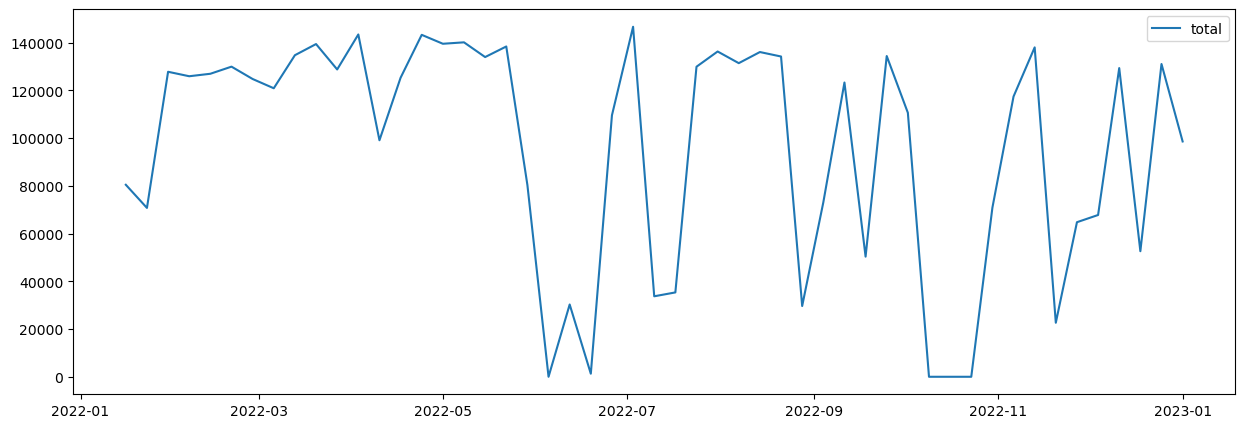

In [545]:
# plot the data 
plt.figure(figsize=(15, 5))
plt.plot(df_weekly)
plt.legend(['total'])
plt.show()

In [546]:
from fancyimpute import IterativeImputer

mice_imputer = IterativeImputer()
# imputing the missing value with mice imputer
df_weekl2y = mice_imputer.fit_transform(df_weekly)
df_weekl2y 


if df_weekly.equals(df_weekl2y):
    print('data_weekly is the same as data_weekl2y')
else:
    print('data_weekly is not the same as data_weekl2y')


data_weekly is not the same as data_weekl2y


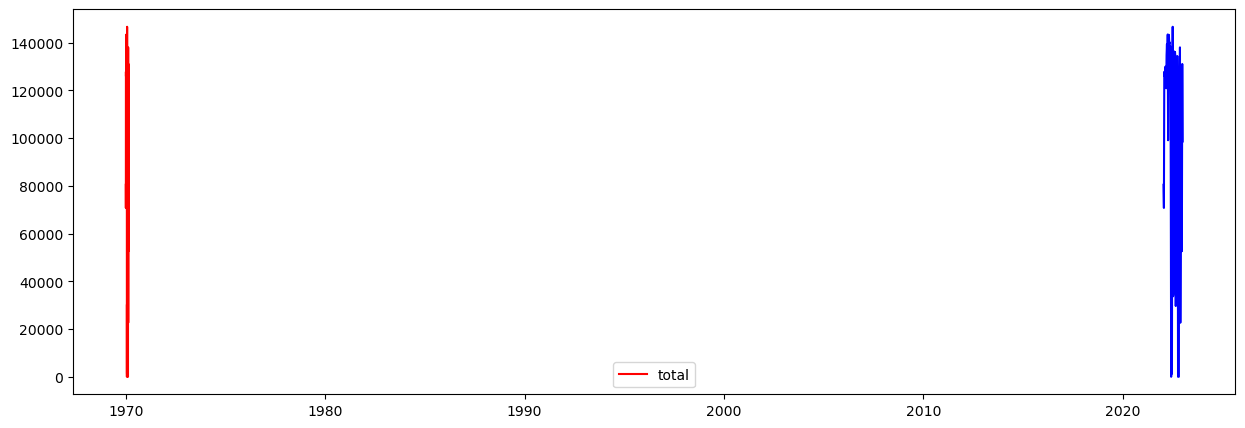

In [547]:
# plot the data 
plt.figure(figsize=(15, 5))
plt.plot(df_weekl2y, color='red')
plt.plot(df_weekly, color='blue')
plt.legend(['total'])
plt.show()


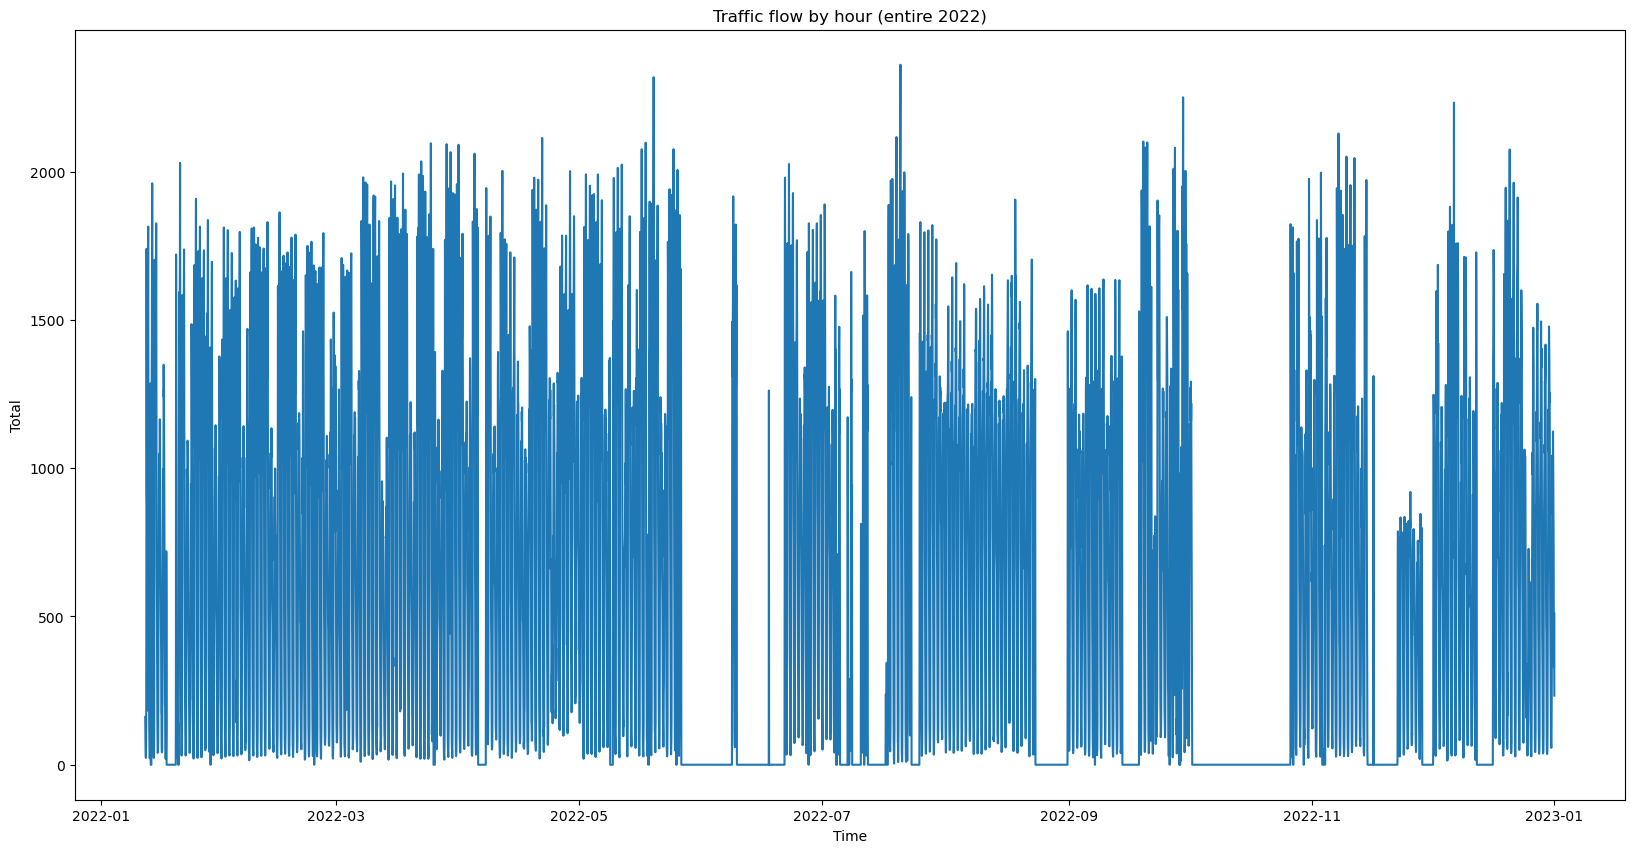

In [548]:
# lets see how the data looks like

plt.figure(figsize=(20,10))
plt.plot(df.index, df['total'])
plt.title('Traffic flow by hour (entire 2022)')
plt.xlabel('Time')
plt.ylabel('Total')
plt.show()


#### from the plot above we can see that there are some missing values, so we need to fill them 
#### we will use the mean of the previous and next values to fill the missing ones

#### Just to have a better understanding of the data, lets plot it by month

In [549]:
df2 = df.copy()

# agregate by month
df2.index = pd.to_datetime(df2.index)
df2 = df2.resample('M').sum()
df2

,total
time_index,
2022-01-31 00:00:00+00:00,298987
2022-02-28 00:00:00+00:00,506736
2022-03-31 00:00:00+00:00,594854
2022-04-30 00:00:00+00:00,545537
2022-05-31 00:00:00+00:00,508433
2022-06-30 00:00:00+00:00,231422
2022-07-31 00:00:00+00:00,391821
2022-08-31 00:00:00+00:00,436313
2022-09-30 00:00:00+00:00,470485


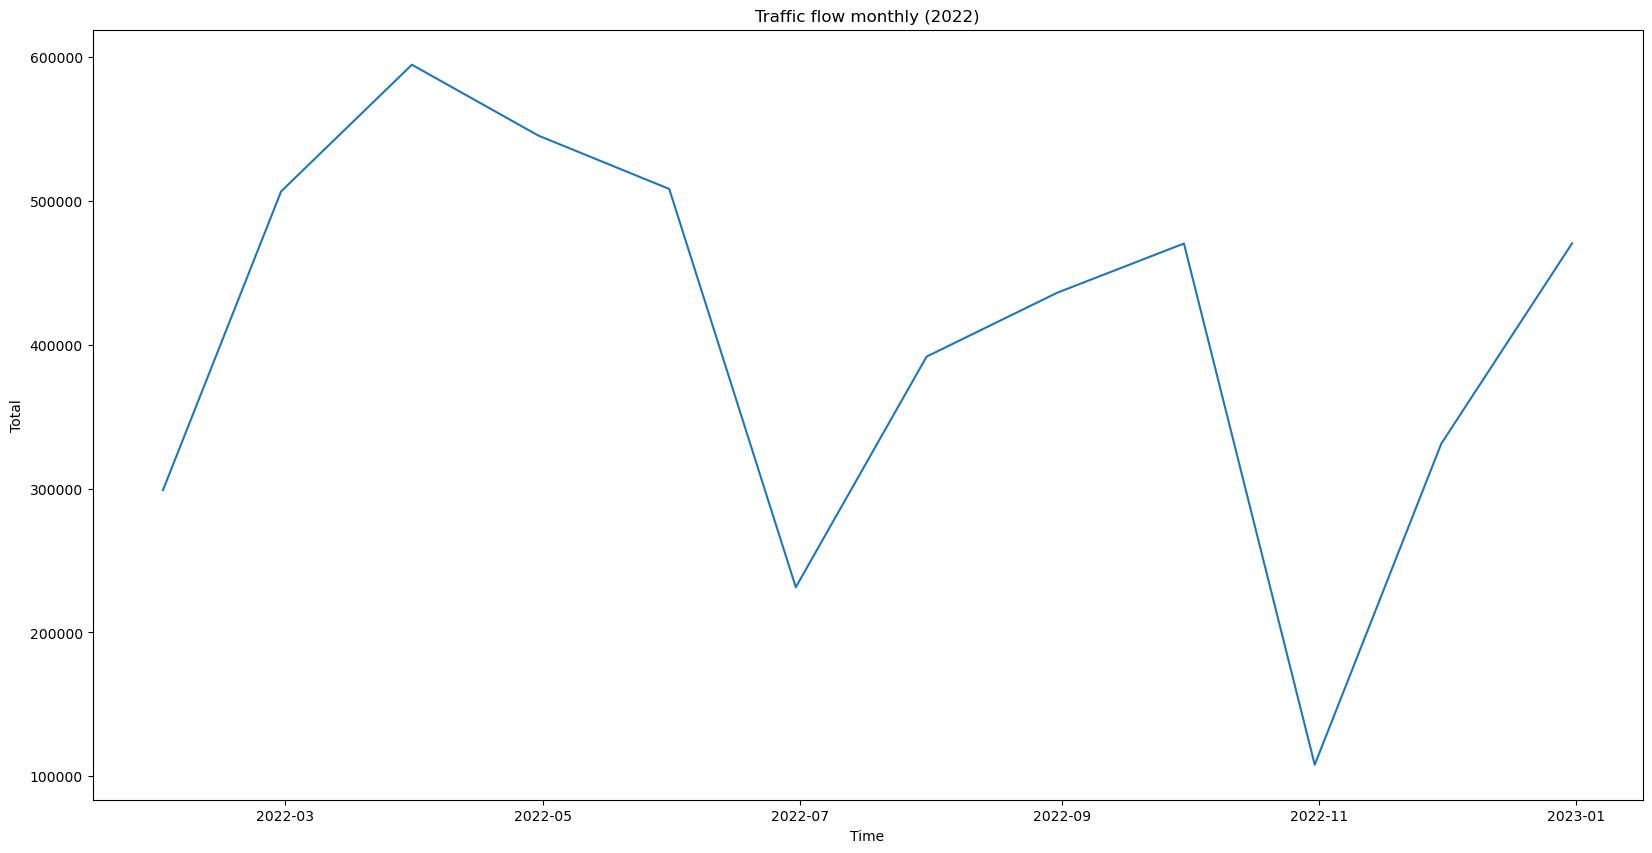

In [550]:
# plot the data
plt.figure(figsize=(20,10))
plt.plot(df2.index, df2['total'])
plt.title('Traffic flow monthly (2022)')
plt.xlabel('Time')
plt.ylabel('Total')
plt.show()

In [551]:
# agregate by day
df3 = df.copy()
df3.index = pd.to_datetime(df3.index)
df3 = df3.resample('D').sum()
df3



,total
time_index,
2022-01-12 00:00:00+00:00,18096
2022-01-13 00:00:00+00:00,13280
2022-01-14 00:00:00+00:00,21058
2022-01-15 00:00:00+00:00,14540
2022-01-16 00:00:00+00:00,13502
...,...
2022-12-27 00:00:00+00:00,17946
2022-12-28 00:00:00+00:00,17527
2022-12-29 00:00:00+00:00,17024


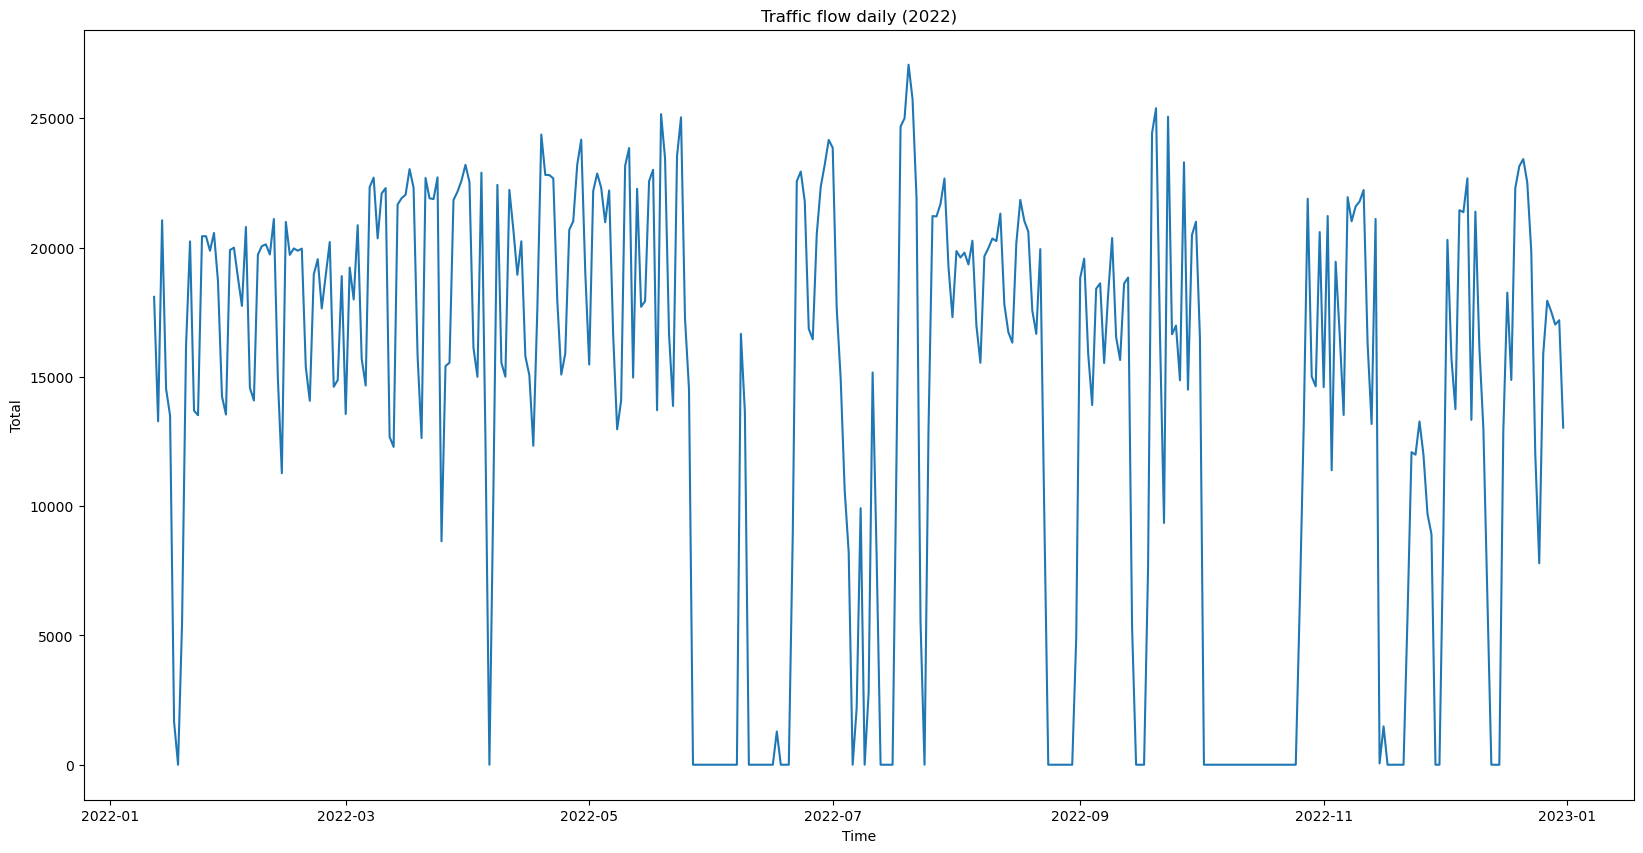

In [552]:
# plot the data
plt.figure(figsize=(20,10))
plt.plot(df3.index, df3['total'])
plt.title('Traffic flow daily (2022)')
plt.xlabel('Time')
plt.ylabel('Total')
plt.show()


#### Now lets normalize the data

In [553]:
# lets normalize the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['total'] = scaler.fit_transform(df[['total']])
df

df3['total'] = scaler.fit_transform(df3[['total']])
df3

df_weekly['total'] = scaler.fit_transform(df_weekly[['total']])
df_weekly


,total
time_index,
2022-01-16 00:00:00+00:00,0.548609
2022-01-23 00:00:00+00:00,0.482470
2022-01-30 00:00:00+00:00,0.871430
2022-02-06 00:00:00+00:00,0.858676
2022-02-13 00:00:00+00:00,0.865752
2022-02-20 00:00:00+00:00,0.886087
2022-02-27 00:00:00+00:00,0.850795
2022-03-06 00:00:00+00:00,0.824338
2022-03-13 00:00:00+00:00,0.918768


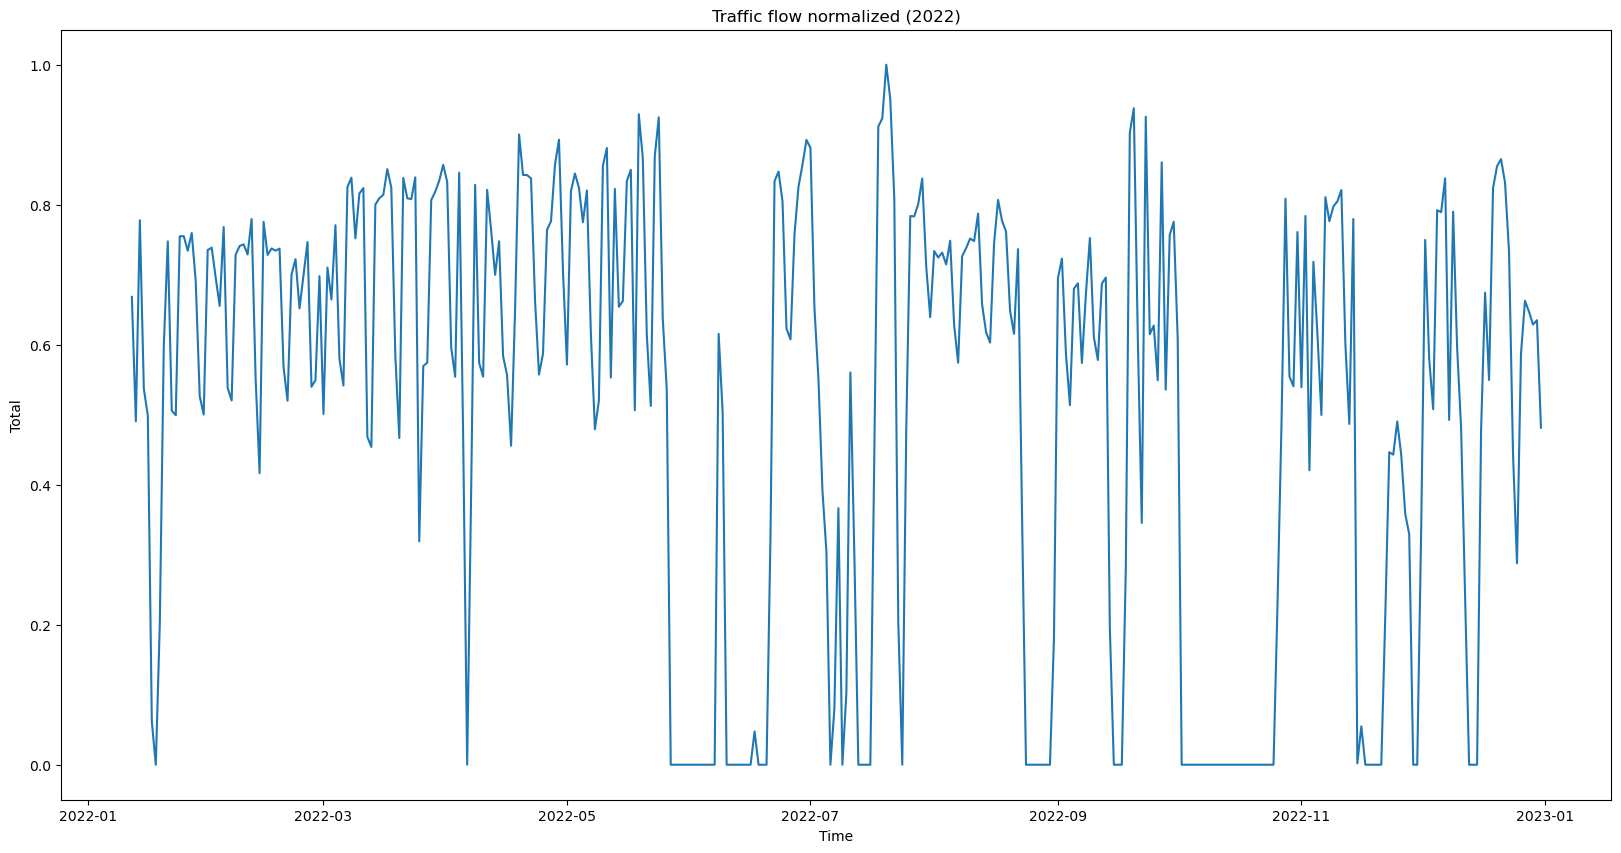

In [554]:
# plot the data normalized
plt.figure(figsize=(20,10))
plt.plot(df3.index, df3['total'])
plt.title('Traffic flow normalized (2022)')
plt.xlabel('Time')
plt.ylabel('Total')
plt.show()


### From the above plot we can see that we have some missing values, so we need to fill them
### We will use the mean of the previous and next values to fill the missing ones

In [555]:
# for all the values that are zero, we will replace them with the mean of the previous and next 20 values
df3['total'] = df3['total'].replace(0, np.nan)
df3['total'] = df3['total'].interpolate(method='linear', limit_direction='both', limit=50)
df3

,total
time_index,
2022-01-12 00:00:00+00:00,0.668366
2022-01-13 00:00:00+00:00,0.490489
2022-01-14 00:00:00+00:00,0.777765
2022-01-15 00:00:00+00:00,0.537027
2022-01-16 00:00:00+00:00,0.498689
...,...
2022-12-27 00:00:00+00:00,0.662825
2022-12-28 00:00:00+00:00,0.647350
2022-12-29 00:00:00+00:00,0.628772


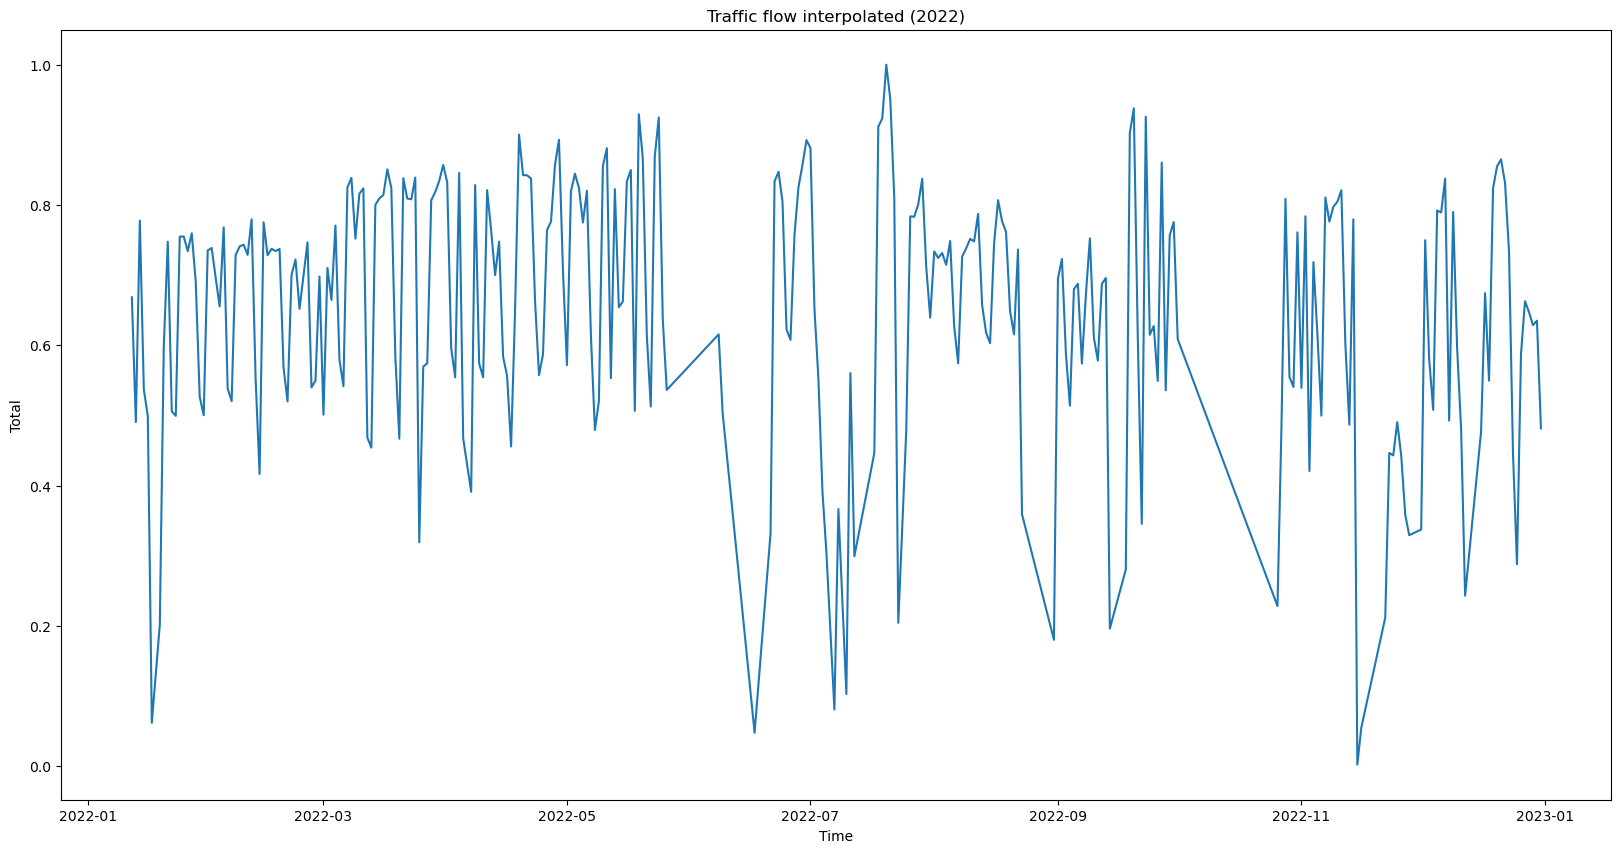

In [556]:
# plot the data interpolated
plt.figure(figsize=(20,10))
plt.plot(df3.index, df3['total'])
plt.title('Traffic flow interpolated (2022)')
plt.xlabel('Time')
plt.ylabel('Total')
plt.show()


In [557]:
# take only the data from may to july
may_july = df['2022-05-20':'2022-07-01']
may_july

,total
time_index,
2022-05-20 00:00:00+00:00,0.049979
2022-05-20 01:00:00+00:00,0.044473
2022-05-20 02:00:00+00:00,0.026260
2022-05-20 03:00:00+00:00,0.017789
2022-05-20 04:00:00+00:00,0.035578
...,...
2022-07-01 19:00:00+00:00,0.593816
2022-07-01 20:00:00+00:00,0.431173
2022-07-01 21:00:00+00:00,0.313427


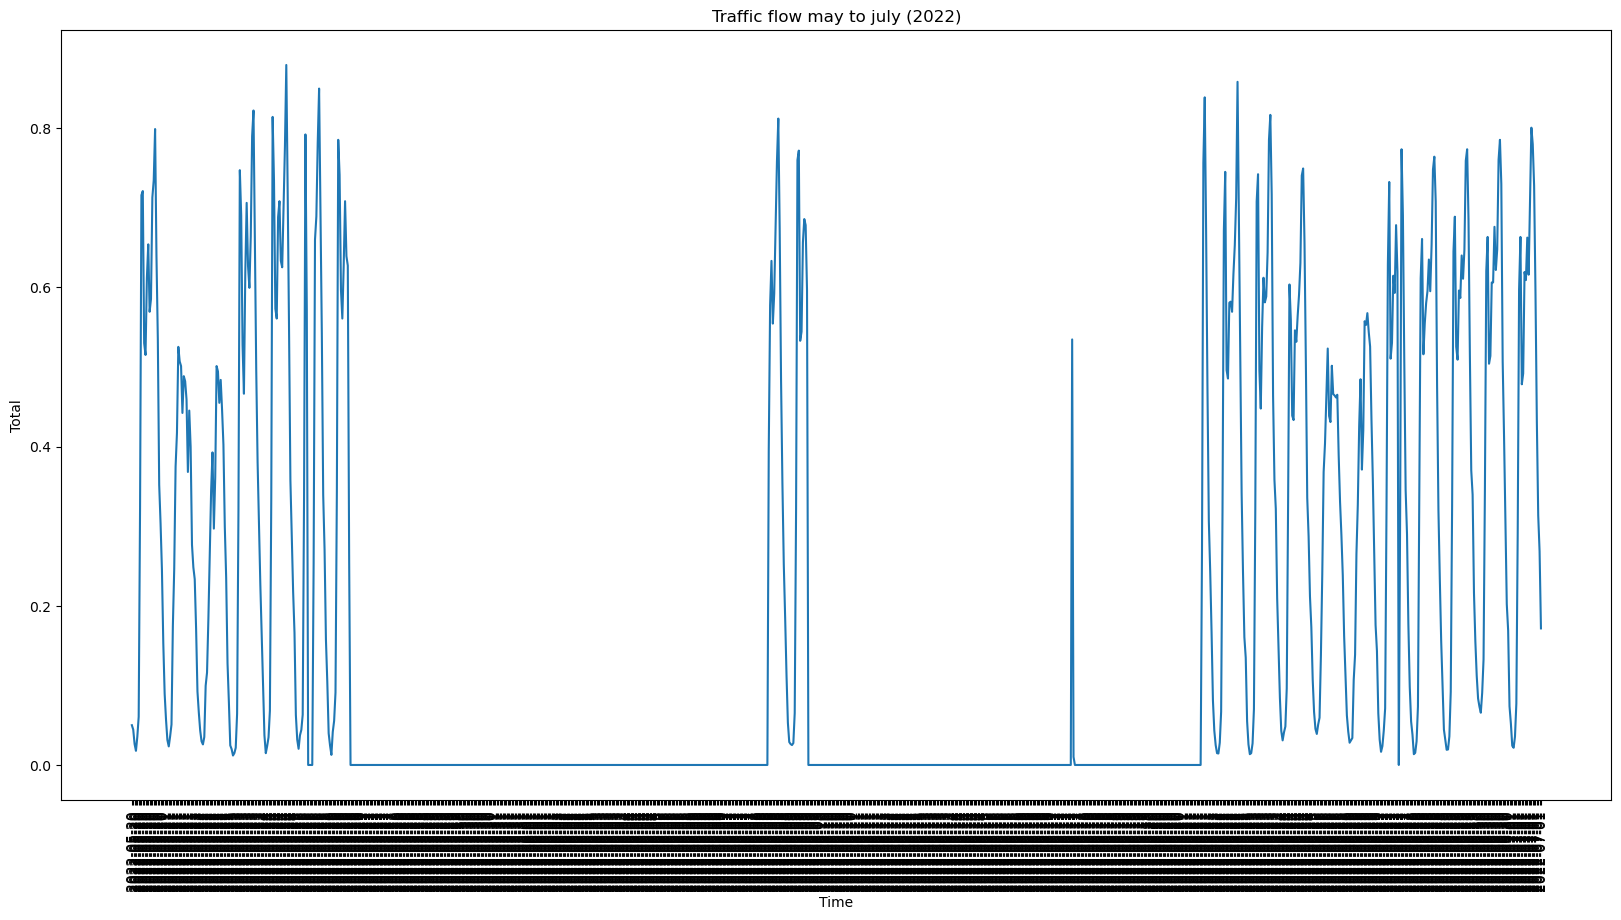

In [558]:
# plot the data
plt.figure(figsize=(20,10))
plt.plot(may_july.index, may_july['total'])
plt.title('Traffic flow may to july (2022)')
plt.xlabel('Time')
plt.ylabel('Total')
# show all the ticks
plt.xticks(may_july.index, rotation=90)
plt.show()


### Once the data is ready, we can start building the model

### Create input and output sequences:  
#### how many previous time steps the model will consider to make predictions (like a window)

#### we should probably consider a window of maybe 14 days (2 weeks) to predict the next 24 hours 

In [559]:
sequence_length = 75  # Define the sequence length

input_sequences = []
output_sequences = []

# Iterate through the DataFrame starting from the sequence length
for i in range(sequence_length, len(df)):
    input_seq = df.iloc[i - sequence_length:i][['total']].values
    output_seq = df.iloc[i]['total']

    input_sequences.append(input_seq)
    output_sequences.append(output_seq)

# Convert the sequences to NumPy arrays
input_sequences = np.array(input_sequences)
output_sequences = np.array(output_sequences)

### Split the data into training and test sets
#### use 80% of the data for training and 20% for testing

In [560]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_sequences, output_sequences, test_size=0.15, random_state=42)

In [561]:
# print the shapes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(7157, 75, 1)
(1264, 75, 1)
(7157,)
(1264,)


## Now that we have the data ready, we can start building the model


# Model - LSTM (Long Short-Term Memory) - DL

In [562]:
# import the libraries
from keras.models import Sequential
from keras.layers import LSTM, Dense

### Create the model

In [563]:
# create the model
model = Sequential()

model.add(LSTM(units=64, input_shape=(sequence_length, 1))) 
model.add(Dense(units=1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')

# train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/30
224/224 [==============================] - 9s 33ms/step - loss: 0.0225 - val_loss: 0.0131
Epoch 2/30
224/224 [==============================] - 7s 30ms/step - loss: 0.0109 - val_loss: 0.0112
Epoch 3/30
224/224 [==============================] - 7s 30ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 4/30
224/224 [==============================] - 7s 30ms/step - loss: 0.0072 - val_loss: 0.0067
Epoch 5/30
224/224 [==============================] - 6s 25ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 6/30
224/224 [==============================] - 4s 16ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 7/30
224/224 [==============================] - 3s 15ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 8/30
224/224 [==============================] - 4s 16ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 9/30
224/224 [==============================] - 4s 17ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 10/30
224/224 [==============================] - 4s 16ms/step - loss: 0.0058 - val_lo

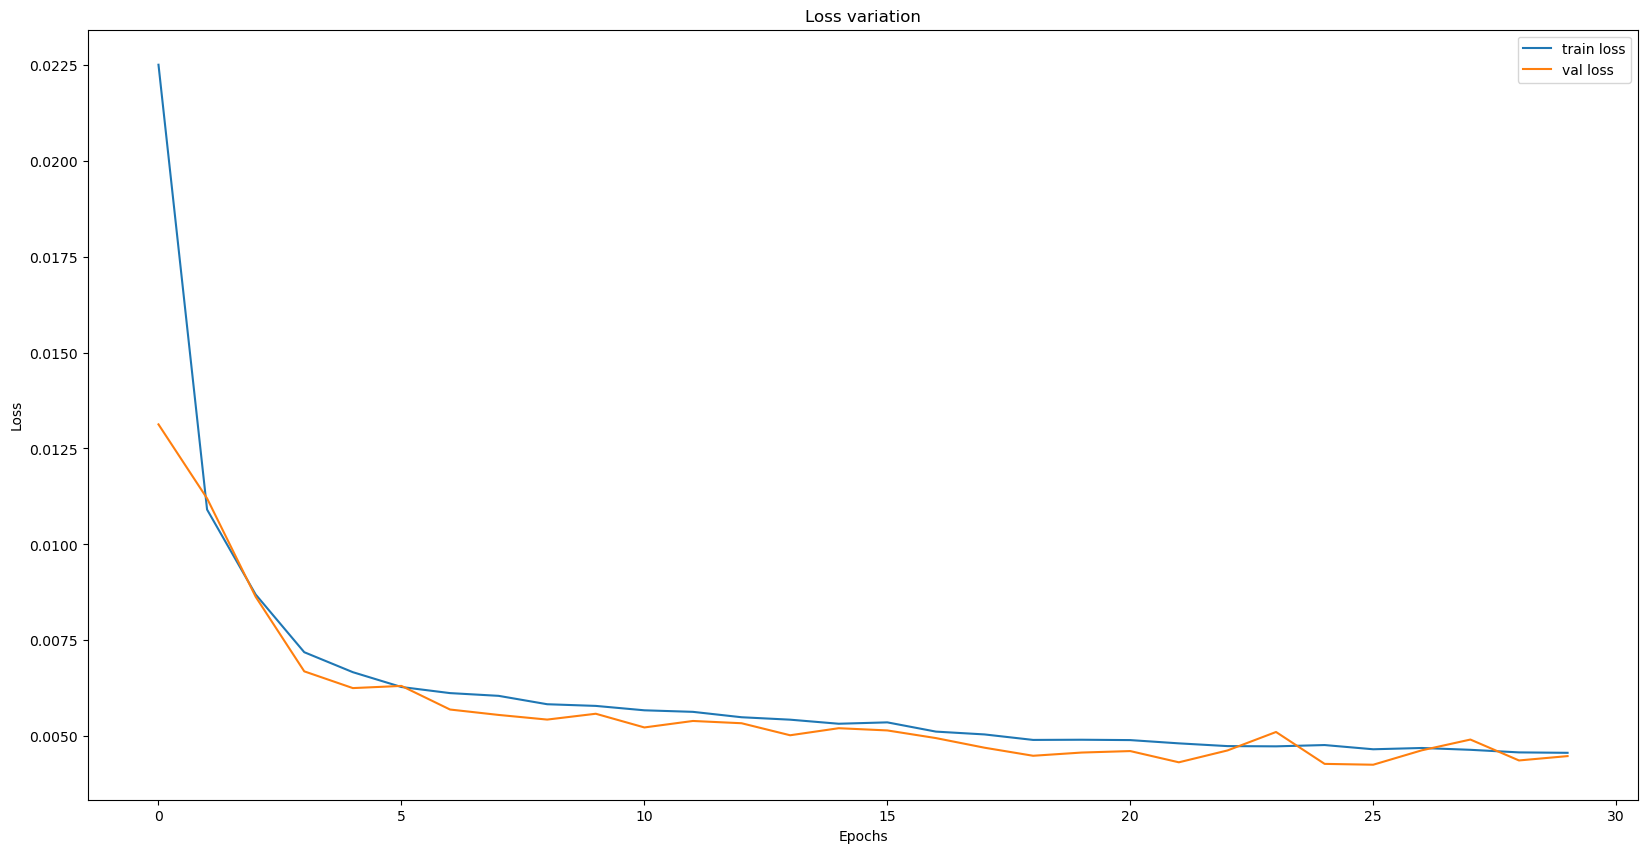

In [564]:
# plot the loss variation 
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss variation')
plt.legend()
plt.show()


### Now lets test the model with the training data

In [565]:
# Evaluate the model on the training data
train_loss = model.evaluate(X_train, y_train)

print('Train Loss: {:.4f}'.format(train_loss))

224/224 [==============================] - 3s 11ms/step - loss: 0.0045
Train Loss: 0.0045


In [566]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# make predictions on training data
train_predictions = model.predict(X_train)

# Calculate evaluation metrics
mse_train = mean_squared_error(y_train, train_predictions)
mae_train = mean_absolute_error(y_train, train_predictions)

print('Train MSE: {:.4f}'.format(mse_train))
print('Train MAE: {:.4f}'.format(mae_train))


224/224 [==============================] - 3s 11ms/step
Train MSE: 0.0045
Train MAE: 0.0379


224/224 [==============================] - 3s 11ms/step


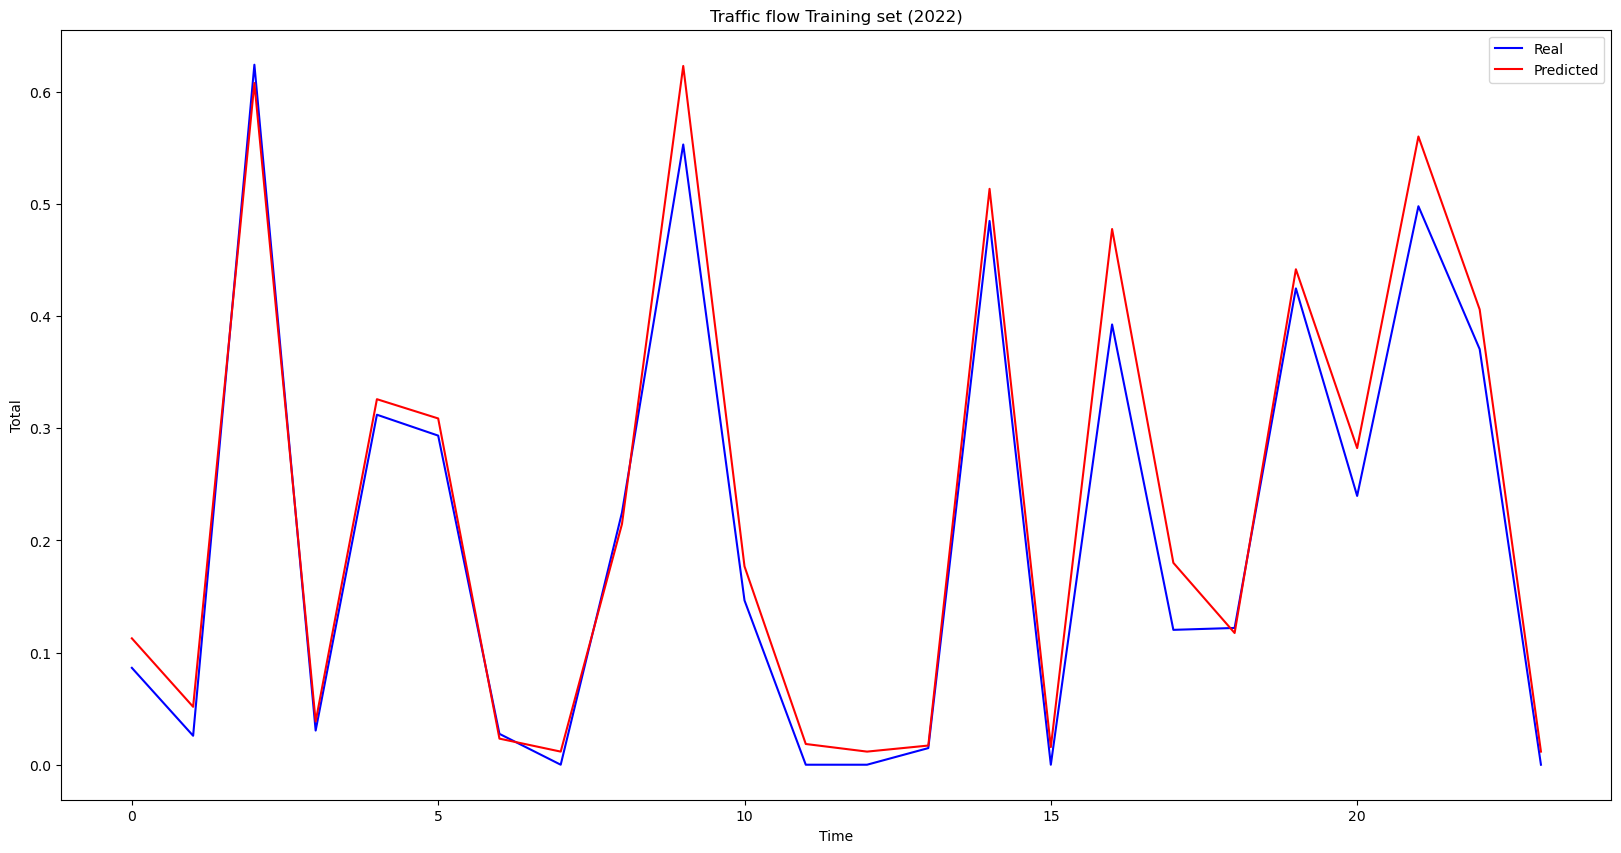

In [567]:
# test the model on the training data
y_pred = model.predict(X_train)

# plot the results
plt.figure(figsize=(20,10))
plt.plot(y_train[:24], color='blue', label='Real')
plt.plot(y_pred[:24], color='red', label='Predicted')
plt.title('Traffic flow Training set (2022)')
plt.xlabel('Time')
plt.ylabel('Total')
plt.legend()
plt.show()

In [568]:
# Evaluate the model on the testing data
loss = model.evaluate(X_test, y_test)

# Make predictions using the model
predictions = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print('Loss: {:.4f}'.format(loss))
print('MSE: {:.4f}'.format(mse))
print('MAE: {:.4f}'.format(mae))

40/40 [==============================] - 0s 11ms/step
Loss: 0.0045
MSE: 0.0045
MAE: 0.0384


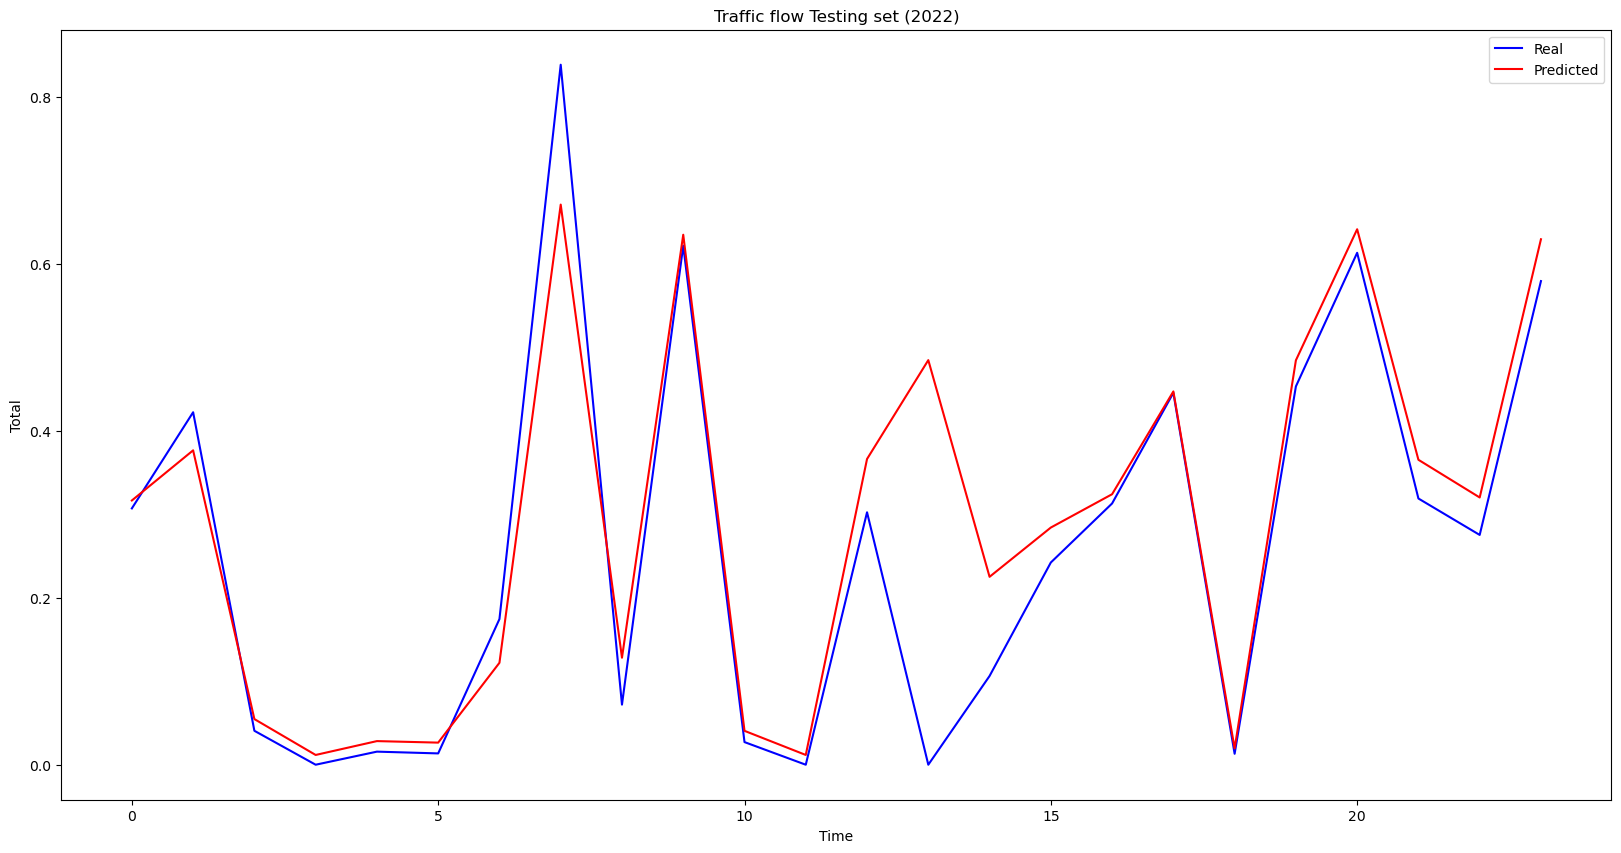

In [569]:
# plot the results 
plt.figure(figsize=(20,10))
plt.plot(y_test[:24], color='blue', label='Real')
plt.plot(predictions[:24], color='red', label='Predicted')
plt.title('Traffic flow Testing set (2022)')
plt.xlabel('Time')
plt.ylabel('Total')
plt.legend()
plt.show()

In [570]:
from scalecast.Forecaster import Forecaster

In [571]:
# conver the index to datetime
df.index = pd.to_datetime(df.index)
df

,total
time_index,
2022-01-12 00:00:00+00:00,0.068191
2022-01-12 01:00:00+00:00,0.032613
2022-01-12 02:00:00+00:00,0.018213
2022-01-12 03:00:00+00:00,0.013130
2022-01-12 04:00:00+00:00,0.009742
...,...
2022-12-31 19:00:00+00:00,0.302414
2022-12-31 20:00:00+00:00,0.169420
2022-12-31 21:00:00+00:00,0.139348


In [572]:
f = Forecaster(
    y=df['total'],
    current_dates=df.index,
    frequency='D',
    train_percentage=0.8,
    forecast_horizon=24,
    verbose=1,
    seasonal_period=355,
    model='LSTM',
    model_parameters={'epochs': 30, 'batch_size': 32, 'loss': 'mean_squared_error', 'optimizer': 'adam'},
)

print(f)
# cannot infer freq from a non-convertible dtype on a Series of datetime64[ns, UTC]

Forecaster object with no models evaluated. Data starts at 2022-01-12 00:00:00+00:00, ends at 2022-12-31 23:00:00+00:00, loaded to forecast out 0 periods, has 0 regressors.


### PACF (Partial Auto Correlation Function) plot:
##### measures how much the y variable, in our case, air passengers, is correlated to past values of itself and how far back a statistically significant correlation exists.

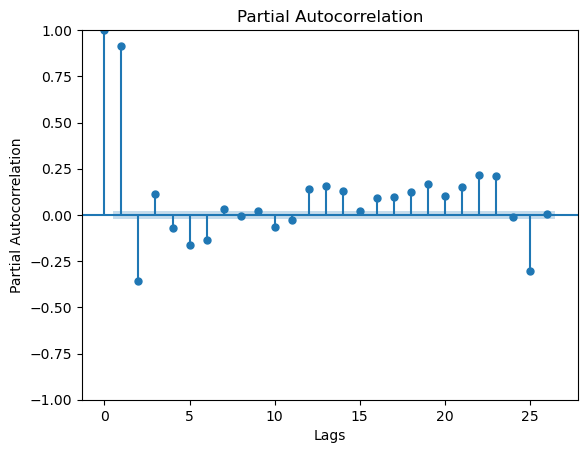

In [573]:
f.plot_pacf(lags=26)
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()


In [574]:
df

,total
time_index,
2022-01-12 00:00:00+00:00,0.068191
2022-01-12 01:00:00+00:00,0.032613
2022-01-12 02:00:00+00:00,0.018213
2022-01-12 03:00:00+00:00,0.013130
2022-01-12 04:00:00+00:00,0.009742
...,...
2022-12-31 19:00:00+00:00,0.302414
2022-12-31 20:00:00+00:00,0.169420
2022-12-31 21:00:00+00:00,0.139348


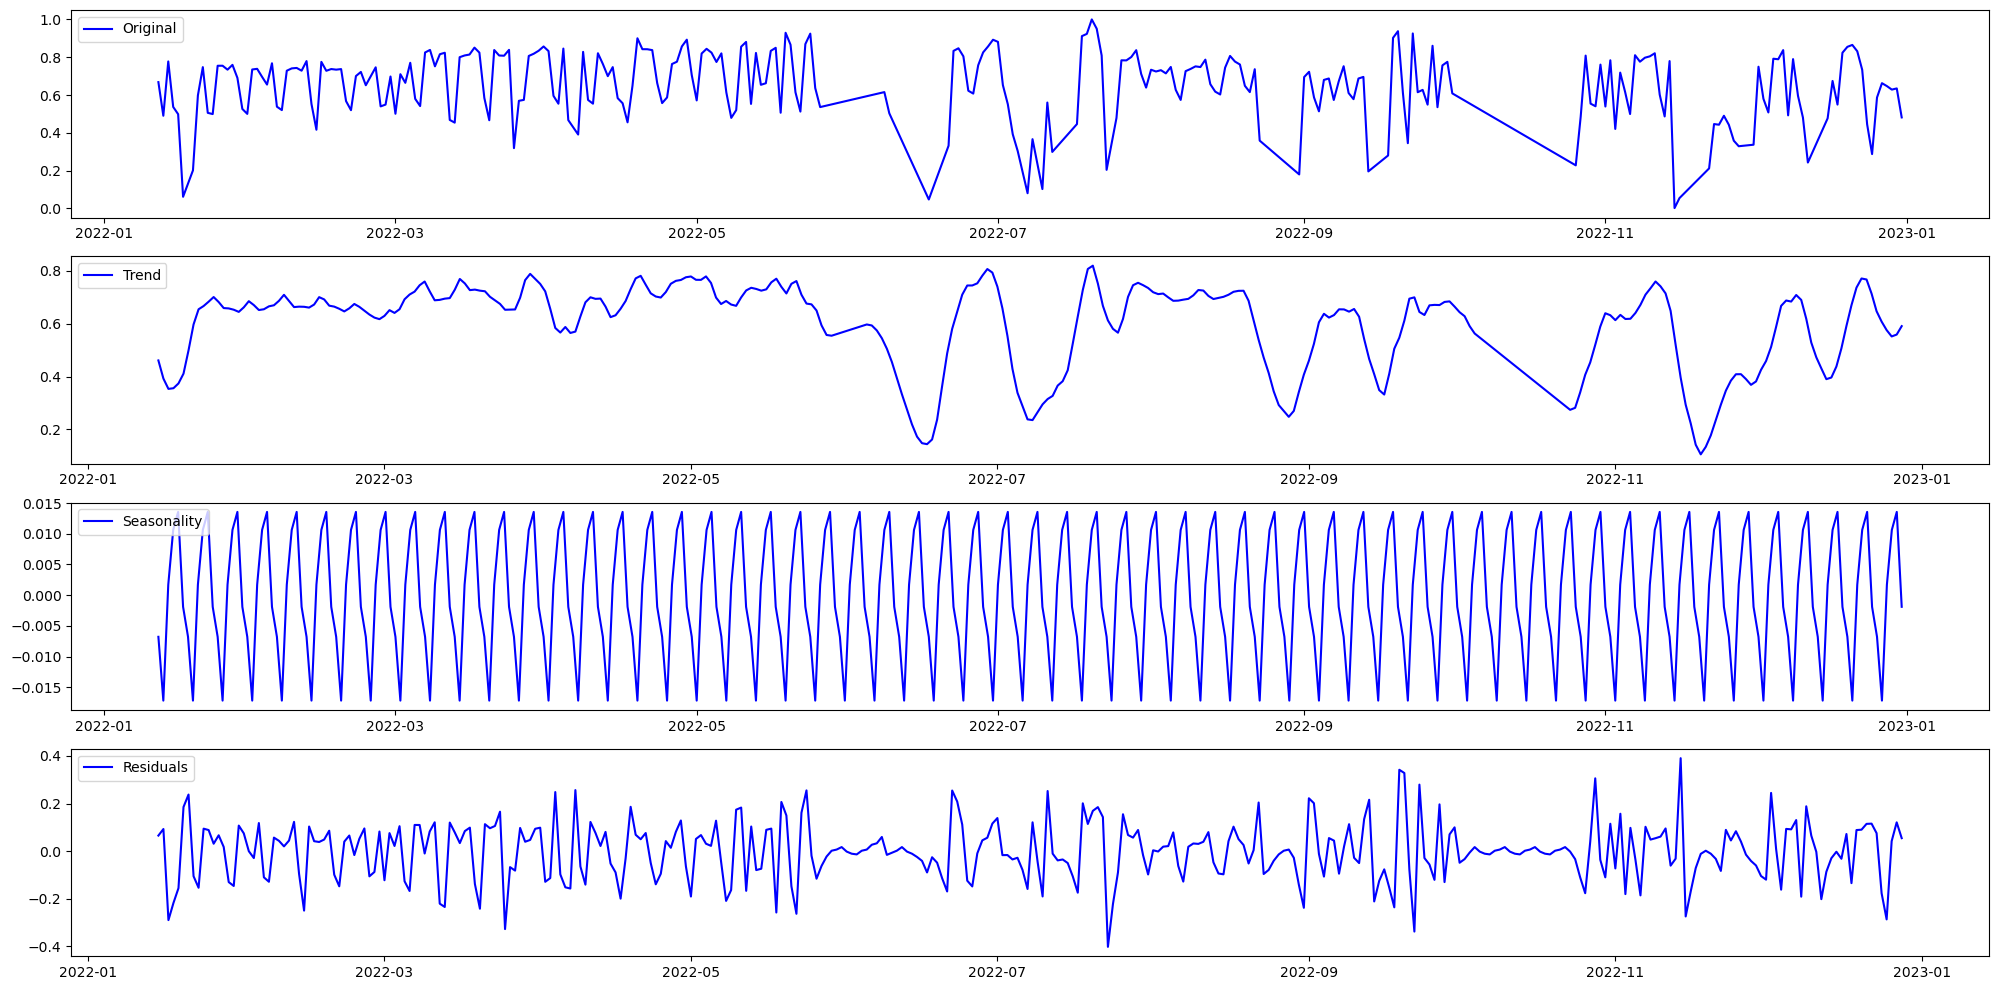

In [575]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
# note that df3 is the daily data
dec = seasonal_decompose(df3['total'], period=6)
    
    ## df3 is the daily data

# Plot the original data, the trend, the seasonality, and the residuals
plt.figure(figsize=(20,10))
plt.subplot(411)
plt.plot(df3['total'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(dec.trend, label='Trend', color='blue')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(dec.seasonal, label='Seasonality', color='blue')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(dec.resid, label='Residuals', color='blue')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()



In [576]:
# instead of daily data, we use the weekly data


We can't really see a trend here, but that doesnt mean that there are no patterns in the data.   
There are probably some patterns, most likely cyclical ones, repeating every 12 months (ano letivo ~).

In [577]:
# lets test the series for stationarity
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('ADF Statistic: {:.4f}'.format(stat))

ADF Statistic: -7.4725


In [578]:
# find the critical value at 5% significance level
from scipy.stats import norm

critical_value = norm.ppf(1 - 0.05)
print('Critical Value: {:.4f}'.format(critical_value))

# check if the ADF statistic is less than the critical value
if stat < critical_value:
    print('Series is Stationary')
else:
    print('Series is Non-Stationary')
    

Critical Value: 1.6449
Series is Stationary


The critical value is derived from statistical tables or computed using statistical software and is based on the desired significance level.  
The significance level represents the threshold below which you would reject the null hypothesis.

In [579]:
df3.index = pd.to_datetime(df3.index)

### Then we can assume that the data is stationary


# ..


In [580]:
series_data = df['total'].values
series_data

array([0.06819144, 0.0326133 , 0.01821262, ..., 0.13934773, 0.21685726,
       0.098687  ])

In [581]:
# get 3rd of October 2022

# get the index of the date
idx = df.index.get_loc('2022-09-26')
idx



slice(6168, 6192, None)

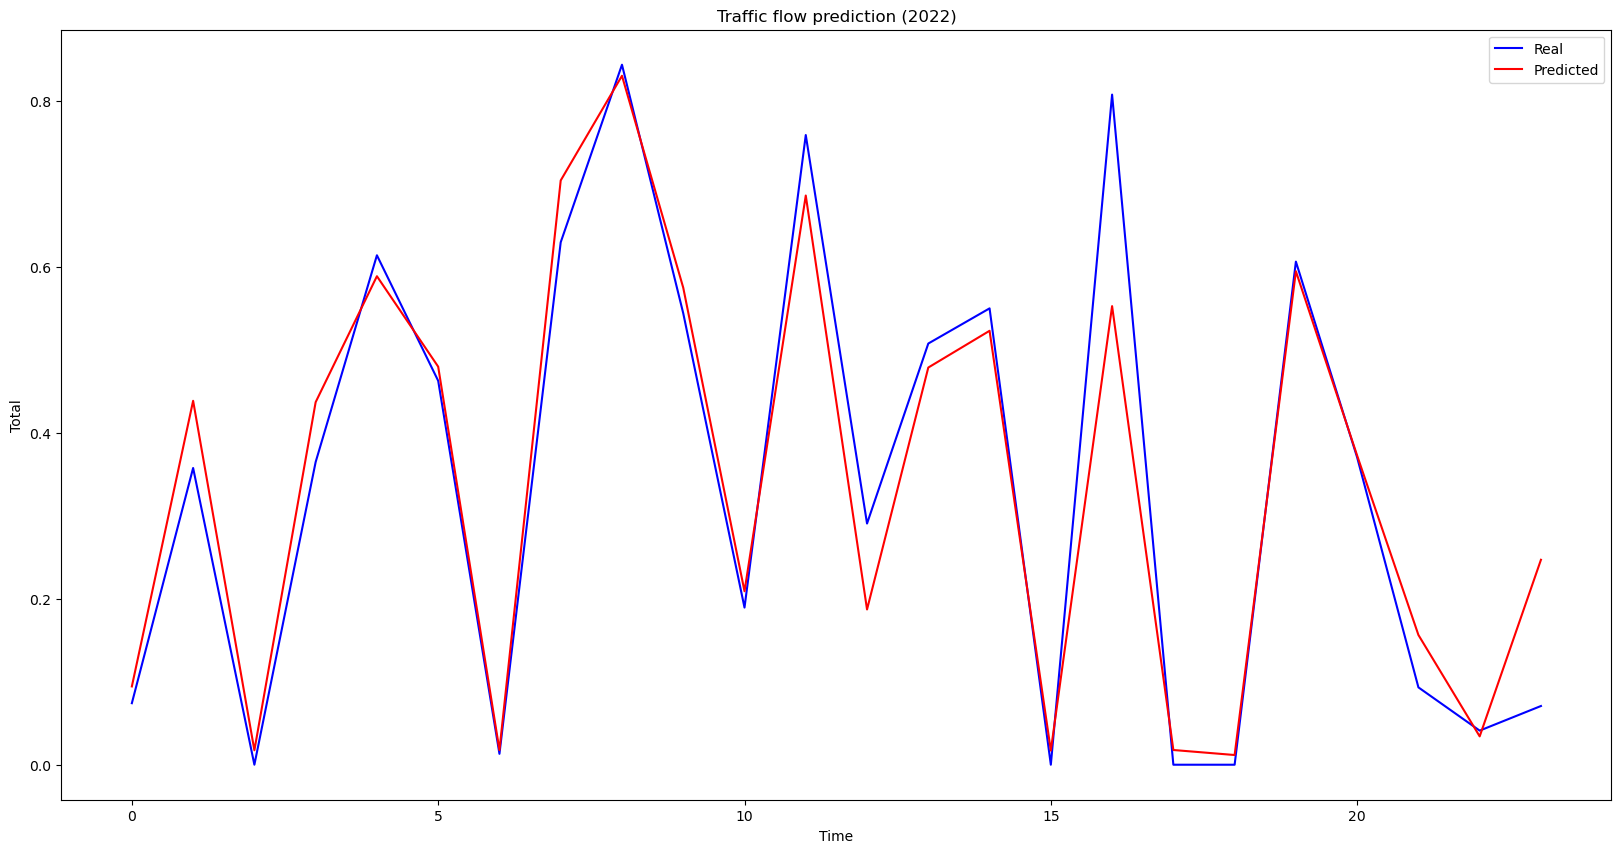

In [582]:
# plot the results 
plt.figure(figsize=(20,10))
plt.plot(y_test[720:744], color='blue', label='Real')
plt.plot(predictions[720:744], color='red', label='Predicted')
plt.title('Traffic flow prediction (2022)')
plt.xlabel('Time')
plt.ylabel('Total')
plt.legend()
plt.show()

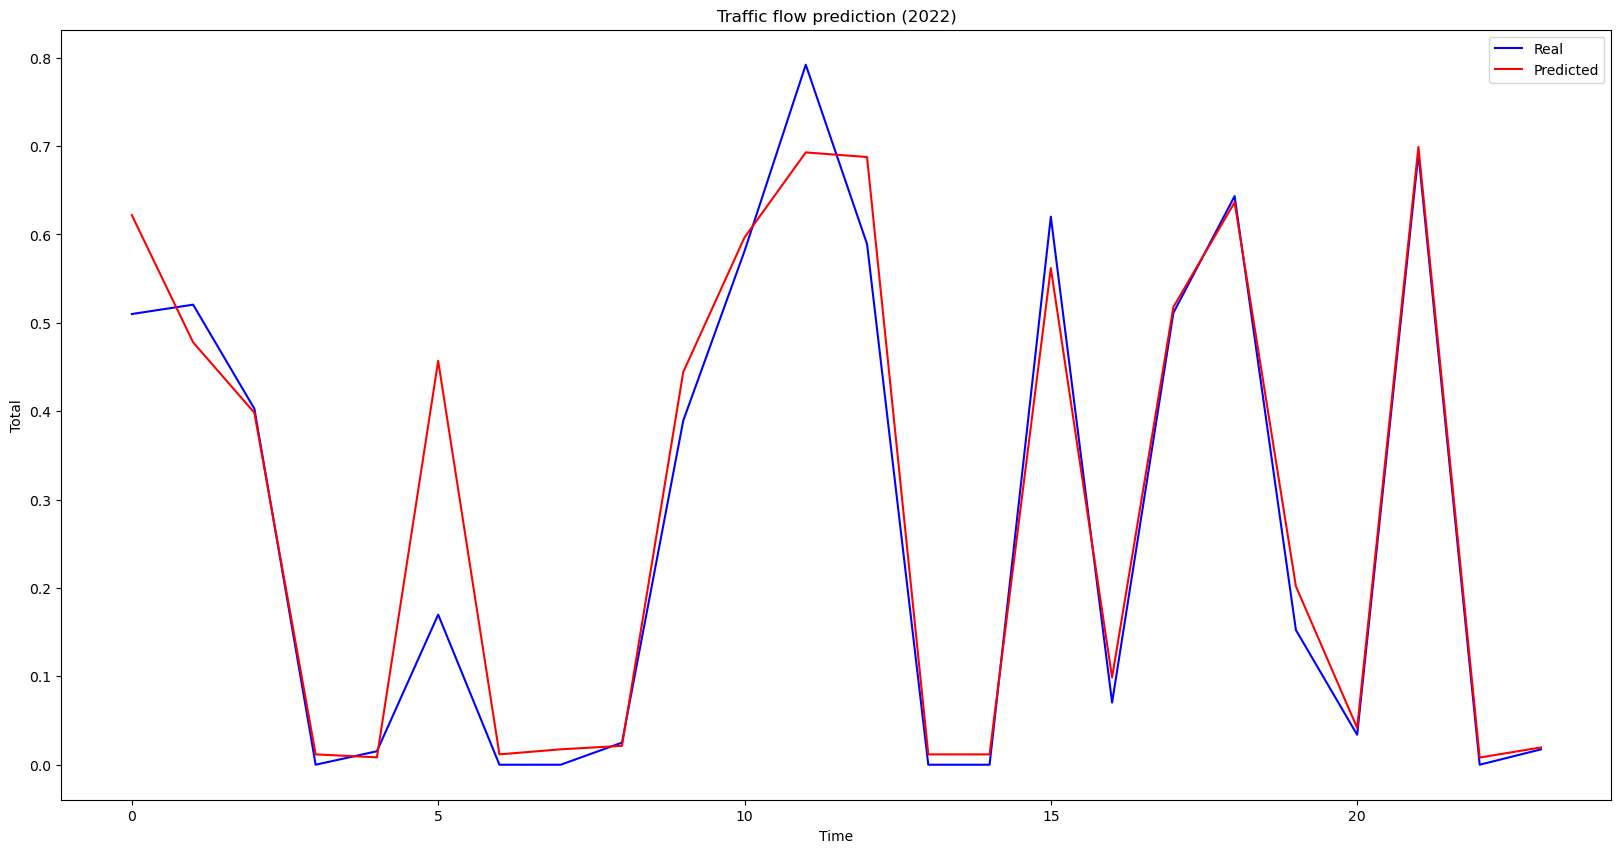

In [583]:
# compare the last 24 hours of the predicted data with the real data (test data)
plt.figure(figsize=(20,10))
plt.plot(y_test[-24:], color='blue', label='Real')
plt.plot(predictions[-24:], color='red', label='Predicted')
plt.title('Traffic flow prediction (2022)')
plt.xlabel('Time')
plt.ylabel('Total')
plt.legend()
plt.show()


In [584]:
series_data.shape  


(8496,)

# Predictions for the next 24 hours 

In [585]:
# demonstrate prediction for next 10 days
# we will use the last 300 entries of the training data as the input to the model
n_steps=350
x_input = series_data[-n_steps:]
# reshape the data
x_input.reshape(1, 350, 1)
temp_input=list(x_input)
lst_output=[]
i=0
while(i < 96):
    
    if(len(temp_input)>n_steps):
        x_input= np.asarray(temp_input[1:]).astype('float32')
        print("{} hour input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} hour output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1
    

print(lst_output)

[0.0914106]
1 hour input [0.536637   0.5374841  0.4798814  0.48792884 0.51969504 0.52901316
 0.5455316  0.49597627 0.50656503 0.4506565  0.29563743 0.29606098
 0.27784836 0.20626853 0.13172385 0.08598052 0.06310885 0.04786108
 0.0292249  0.04404913 0.09191021 0.10546379 0.1956798  0.3011436
 0.39347735 0.4489623  0.3612876  0.41296062 0.49978822 0.4506565
 0.43879712 0.5167302  0.4231258  0.38246506 0.3193562  0.21304531
 0.13934773 0.08936891 0.04108429 0.01651843 0.01313003 0.02287166
 0.02498941 0.06946209 0.29479036 0.70097417 0.6488776  0.5565438
 0.5052944  0.5887336  0.6675138  0.62007624 0.6179585  0.6556544
 0.7649301  0.82422704 0.6598899  0.42820838 0.2727658  0.20415078
 0.15925455 0.09106311 0.03684879 0.07327404 0.02244812 0.04447268
 0.13087675 0.07073274 0.29775518 0.77721304 0.69419736 0.49894112
 0.5108005  0.53197795 0.6543837  0.62431175 0.6264295  0.6302414
 0.74883527 0.8788649  0.5887336  0.47945786 0.31215587 0.25540024
 0.22532825 0.11986446 0.06988564 0.041931

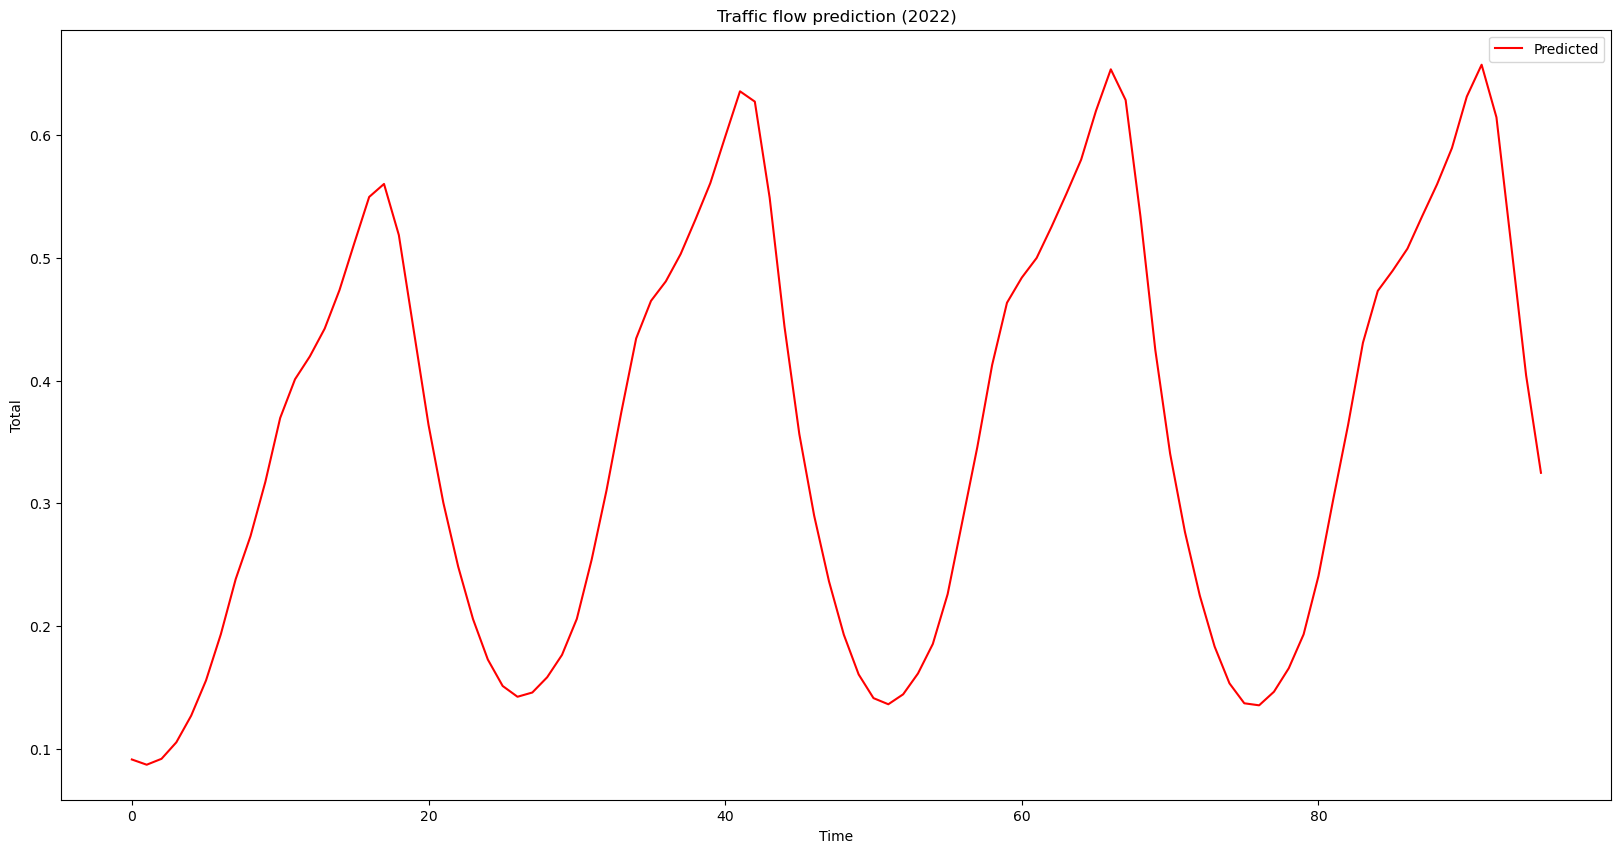

In [586]:
# plot the results
plt.figure(figsize=(20,10))
plt.plot(lst_output, color='red', label='Predicted')
plt.title('Traffic flow prediction (2022)')
plt.xlabel('Time')
plt.ylabel('Total')
plt.legend()
plt.show()

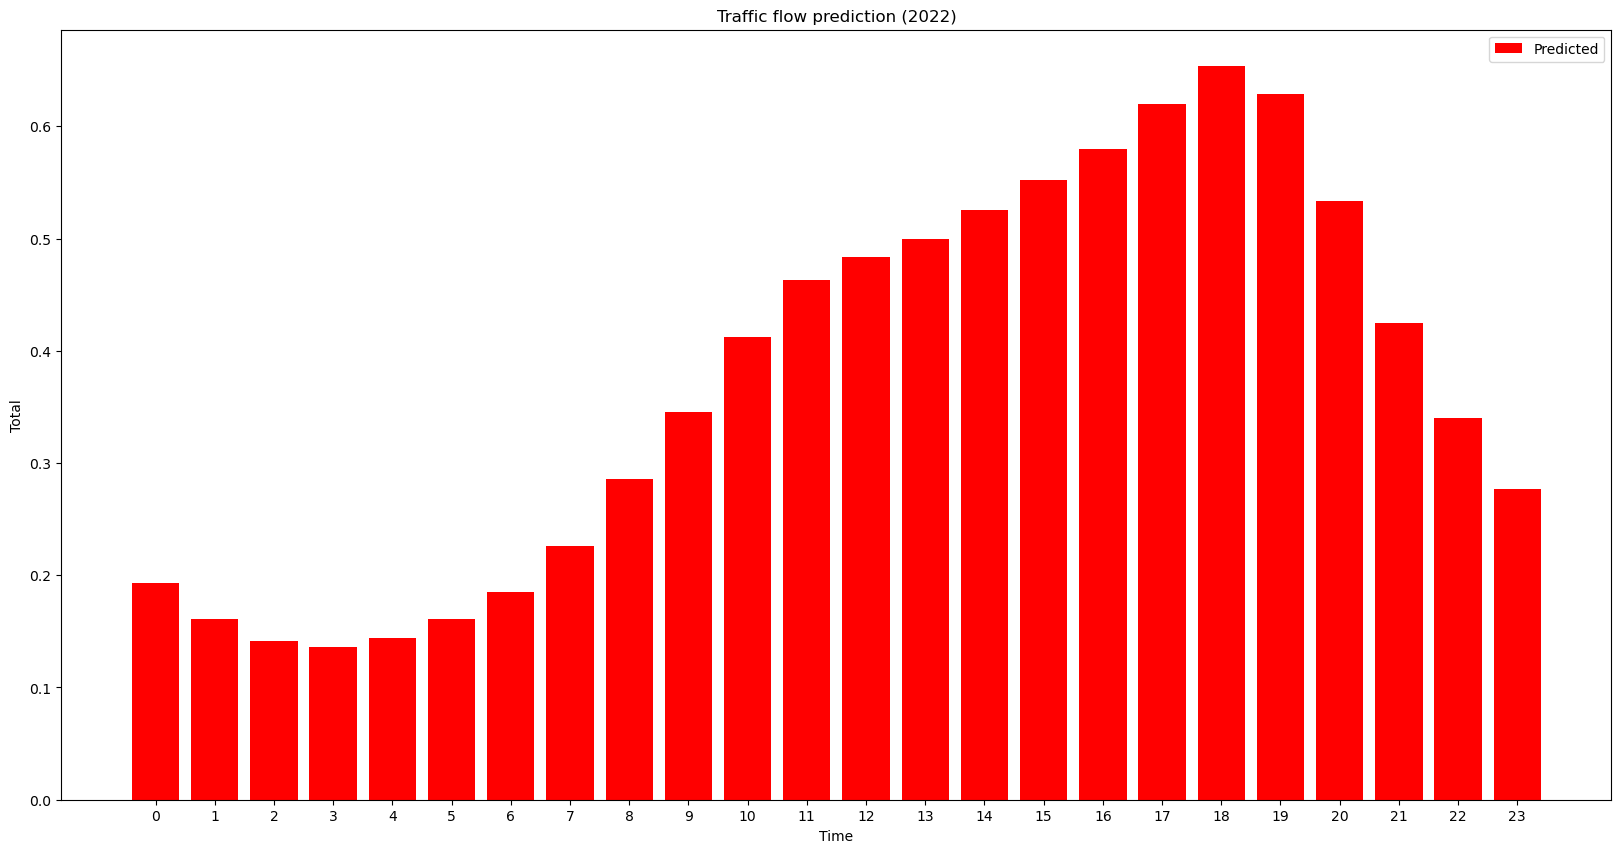

In [587]:
plt.figure(figsize=(20,10))
plt.bar(np.arange(0, 24, 1), lst_output[48:72], color='red', label='Predicted')
plt.title('Traffic flow prediction (2022)')
plt.xlabel('Time')
plt.xticks(np.arange(0, 24, 1))
plt.ylabel('Total')
plt.legend()
plt.show()
